In [69]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.neighbors import DistanceMetric
from math import radians
import folium
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import nearest_points

# agosto


 Faltam os dias 3, 4, 5, 6, 12, 19, 26, 27

In [70]:
agosto = pd.read_csv('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/passengers_agosto.csv',
                    index_col= 'Unnamed: 0')

    #  Sao 214k linhas

In [71]:
agosto

,device_id,timestampI,timestampF,MAC,RSSI,channel,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,id,duration
0,617.0,1627887032,1627888203,24:fd:0d:bd:91:49,-83,1,-22.827640,-47.061036,-22.823898,-47.063036,2,0,1171
1,617.0,1627887033,1627889664,40:06:a0:5b:8c:b2,-51,12,-22.827717,-47.061002,-22.829839,-47.060069,27,1,2631
2,617.0,1627887034,1627888255,78:04:73:0a:8d:90,-85,11,-22.827797,-47.060968,-22.827860,-47.060928,9,2,1221
3,617.0,1627887040,1627889664,0c:ef:af:d3:00:36,-62,11,-22.828329,-47.060821,-22.829839,-47.060069,94,6,2624
4,617.0,1627887069,1627888309,6e:f2:cc:ea:6a:64,-93,11,-22.829653,-47.060836,-22.829349,-47.062100,50,9,1240
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262086,NaN,1630437998,1630437998,70:ca:97:02:fa:e8,-96,11,-22.816053,-47.072787,-22.816053,-47.072787,2,406,0
262087,NaN,1630438003,1630438003,80:d0:4a:94:9b:1c,-85,6,-22.816329,-47.072811,-22.816329,-47.072811,2,407,0
262088,NaN,1630438006,1630438007,26:93:8f:55:ef:1c,-91,6,-22.816426,-47.072812,-22.816448,-47.072808,7,408,1
262089,NaN,1630438010,1630438031,68:02:b8:5d:41:da,-90,11,-22.816470,-47.072796,-22.816554,-47.072769,2,409,21



## Preparacao dos dados

In [72]:
agosto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262091 entries, 0 to 262090
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   device_id   121637 non-null  float64
 1   timestampI  262091 non-null  int64  
 2   timestampF  262091 non-null  int64  
 3   MAC         262091 non-null  object 
 4   RSSI        262091 non-null  int64  
 5   channel     262091 non-null  int64  
 6   latitudeI   262091 non-null  float64
 7   longitudeI  262091 non-null  float64
 8   latitudeF   262091 non-null  float64
 9   longitudeF  262091 non-null  float64
 10  cnt_pckg    262091 non-null  int64  
 11  id          262091 non-null  int64  
 12  duration    262091 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 28.0+ MB


In [73]:
## Tranforma timestamp em datas

agosto['dataInicio'] = pd.to_datetime(agosto['timestampI'], unit='s')
agosto['dataFim'] = pd.to_datetime(agosto['timestampF'], unit='s')

In [74]:
agosto = agosto[['MAC','latitudeI', 'longitudeI', 'latitudeF', 'longitudeF', 'cnt_pckg', 'duration', 'dataInicio', 'dataFim']]

In [75]:
## Cria a coluna com o dia de cada ping para os agrupamentos

agosto['day'] = agosto.dataInicio.dt.day

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1689/691738157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agosto['day'] = agosto.dataInicio.dt.day


In [76]:
agosto.drop(index = agosto[ agosto.dataInicio.dt.day  !=  agosto.dataFim.dt.day ].index , inplace = True)
agosto.reset_index(drop = True)

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1689/2501127589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agosto.drop(index = agosto[ agosto.dataInicio.dt.day  !=  agosto.dataFim.dt.day ].index , inplace = True)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day
0,24:fd:0d:bd:91:49,-22.827640,-47.061036,-22.823898,-47.063036,2,1171,2021-08-02 06:50:32,2021-08-02 07:10:03,2
1,40:06:a0:5b:8c:b2,-22.827717,-47.061002,-22.829839,-47.060069,27,2631,2021-08-02 06:50:33,2021-08-02 07:34:24,2
2,78:04:73:0a:8d:90,-22.827797,-47.060968,-22.827860,-47.060928,9,1221,2021-08-02 06:50:34,2021-08-02 07:10:55,2
3,0c:ef:af:d3:00:36,-22.828329,-47.060821,-22.829839,-47.060069,94,2624,2021-08-02 06:50:40,2021-08-02 07:34:24,2
4,6e:f2:cc:ea:6a:64,-22.829653,-47.060836,-22.829349,-47.062100,50,1240,2021-08-02 06:51:09,2021-08-02 07:11:49,2
...,...,...,...,...,...,...,...,...,...,...
262010,70:ca:97:02:fa:e8,-22.816053,-47.072787,-22.816053,-47.072787,2,0,2021-08-31 19:26:38,2021-08-31 19:26:38,31
262011,80:d0:4a:94:9b:1c,-22.816329,-47.072811,-22.816329,-47.072811,2,0,2021-08-31 19:26:43,2021-08-31 19:26:43,31
262012,26:93:8f:55:ef:1c,-22.816426,-47.072812,-22.816448,-47.072808,7,1,2021-08-31 19:26:46,2021-08-31 19:26:47,31
262013,68:02:b8:5d:41:da,-22.816470,-47.072796,-22.816554,-47.072769,2,21,2021-08-31 19:26:50,2021-08-31 19:27:11,31


In [77]:
## Cria coluna de ID para cada um dos MACS para facilitar identificacao

MACs_unicos = agosto.MAC.unique()

temp = defaultdict(lambda: len(temp))
device_id = [temp[ele] for ele in MACs_unicos]

res = dict(zip(MACs_unicos, device_id))

agosto['device_id'] = agosto['MAC'].map(res)
agosto

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1689/1828378363.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agosto['device_id'] = agosto['MAC'].map(res)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id
0,24:fd:0d:bd:91:49,-22.827640,-47.061036,-22.823898,-47.063036,2,1171,2021-08-02 06:50:32,2021-08-02 07:10:03,2,0
1,40:06:a0:5b:8c:b2,-22.827717,-47.061002,-22.829839,-47.060069,27,2631,2021-08-02 06:50:33,2021-08-02 07:34:24,2,1
2,78:04:73:0a:8d:90,-22.827797,-47.060968,-22.827860,-47.060928,9,1221,2021-08-02 06:50:34,2021-08-02 07:10:55,2,2
3,0c:ef:af:d3:00:36,-22.828329,-47.060821,-22.829839,-47.060069,94,2624,2021-08-02 06:50:40,2021-08-02 07:34:24,2,3
4,6e:f2:cc:ea:6a:64,-22.829653,-47.060836,-22.829349,-47.062100,50,1240,2021-08-02 06:51:09,2021-08-02 07:11:49,2,4
...,...,...,...,...,...,...,...,...,...,...,...
262086,70:ca:97:02:fa:e8,-22.816053,-47.072787,-22.816053,-47.072787,2,0,2021-08-31 19:26:38,2021-08-31 19:26:38,31,9098
262087,80:d0:4a:94:9b:1c,-22.816329,-47.072811,-22.816329,-47.072811,2,0,2021-08-31 19:26:43,2021-08-31 19:26:43,31,625
262088,26:93:8f:55:ef:1c,-22.816426,-47.072812,-22.816448,-47.072808,7,1,2021-08-31 19:26:46,2021-08-31 19:26:47,31,12824
262089,68:02:b8:5d:41:da,-22.816470,-47.072796,-22.816554,-47.072769,2,21,2021-08-31 19:26:50,2021-08-31 19:27:11,31,1876


In [78]:
## Adiciona sequence para identificar dentro de um dia de qual a o numero da conexao atual (em uma lista ordenada)

agosto.sort_values(by= ['device_id', 'dataInicio'], inplace = True)

agosto['sequence'] = agosto.groupby(['device_id', 'day']).cumcount()+1

agosto.reset_index(drop = True, inplace = True)

agosto

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1689/4154853382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agosto.sort_values(by= ['device_id', 'dataInicio'], inplace = True)
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1689/4154853382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agosto['sequence'] = agosto.groupby(['device_id', 'day']).cumcount()+1


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence
0,24:fd:0d:bd:91:49,-22.827640,-47.061036,-22.823898,-47.063036,2,1171,2021-08-02 06:50:32,2021-08-02 07:10:03,2,0,1
1,24:fd:0d:bd:91:49,-22.827359,-47.061153,-22.827880,-47.060955,5,42,2021-08-02 08:19:14,2021-08-02 08:19:56,2,0,2
2,24:fd:0d:bd:91:49,-22.827686,-47.061002,-22.827686,-47.061002,1,0,2021-08-02 11:11:01,2021-08-02 11:11:01,2,0,3
3,24:fd:0d:bd:91:49,-22.826736,-47.061428,-22.826867,-47.061473,2,25,2021-08-02 11:55:30,2021-08-02 11:55:55,2,0,4
4,24:fd:0d:bd:91:49,-22.827635,-47.061051,-22.827635,-47.061051,1,0,2021-08-02 15:08:13,2021-08-02 15:08:13,2,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
262010,32:4b:bf:fa:8c:4a,-22.819221,-47.064676,-22.819221,-47.064676,1,0,2021-08-31 19:19:11,2021-08-31 19:19:11,31,93714,1
262011,b6:e9:5d:f5:b5:4a,-22.818655,-47.064263,-22.818655,-47.064263,4,0,2021-08-31 19:19:24,2021-08-31 19:19:24,31,93715,1
262012,5a:17:cb:db:6c:0d,-22.817414,-47.063752,-22.817310,-47.063721,2,1,2021-08-31 19:19:45,2021-08-31 19:19:46,31,93716,1
262013,2e:45:9d:cd:45:0d,-22.813378,-47.064453,-22.813378,-47.064453,1,0,2021-08-31 19:20:48,2021-08-31 19:20:48,31,93717,1


In [79]:
agosto['periodo'] = None

agosto.loc[agosto['dataInicio'].dt.hour <= 12, 'periodo'] =  'Manha'
agosto.loc[agosto['dataInicio'].dt.hour > 12, 'periodo'] =  'Tarde'
agosto

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1689/3236128949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agosto['periodo'] = None


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,periodo
0,24:fd:0d:bd:91:49,-22.827640,-47.061036,-22.823898,-47.063036,2,1171,2021-08-02 06:50:32,2021-08-02 07:10:03,2,0,1,Manha
1,24:fd:0d:bd:91:49,-22.827359,-47.061153,-22.827880,-47.060955,5,42,2021-08-02 08:19:14,2021-08-02 08:19:56,2,0,2,Manha
2,24:fd:0d:bd:91:49,-22.827686,-47.061002,-22.827686,-47.061002,1,0,2021-08-02 11:11:01,2021-08-02 11:11:01,2,0,3,Manha
3,24:fd:0d:bd:91:49,-22.826736,-47.061428,-22.826867,-47.061473,2,25,2021-08-02 11:55:30,2021-08-02 11:55:55,2,0,4,Manha
4,24:fd:0d:bd:91:49,-22.827635,-47.061051,-22.827635,-47.061051,1,0,2021-08-02 15:08:13,2021-08-02 15:08:13,2,0,5,Tarde
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262010,32:4b:bf:fa:8c:4a,-22.819221,-47.064676,-22.819221,-47.064676,1,0,2021-08-31 19:19:11,2021-08-31 19:19:11,31,93714,1,Tarde
262011,b6:e9:5d:f5:b5:4a,-22.818655,-47.064263,-22.818655,-47.064263,4,0,2021-08-31 19:19:24,2021-08-31 19:19:24,31,93715,1,Tarde
262012,5a:17:cb:db:6c:0d,-22.817414,-47.063752,-22.817310,-47.063721,2,1,2021-08-31 19:19:45,2021-08-31 19:19:46,31,93716,1,Tarde
262013,2e:45:9d:cd:45:0d,-22.813378,-47.064453,-22.813378,-47.064453,1,0,2021-08-31 19:20:48,2021-08-31 19:20:48,31,93717,1,Tarde


In [80]:

##### OUTDATED #####

## Criando coluna de duracao da conexao entre os pings



agosto['duration(s)'] = (agosto['dataFim'] - agosto['dataInicio']).dt.total_seconds()

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1689/546158693.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agosto['duration(s)'] = (agosto['dataFim'] - agosto['dataInicio']).dt.total_seconds()


In [81]:
## funcao de calculo de distancia entre o ponto de inicio e fim da conexao

def haversine_vectorize(lon1, lat1, lon2, lat2):
    # print(lon1, lat1, lon2, lat2)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    m = 6_367_000 * dist #6367 for distance in KM for miles use 3958
    return m

agosto['distance(m)'] = agosto.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']) * 1.2, axis = 1)


agosto

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_1689/2239663589.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agosto['distance(m)'] = agosto.apply(lambda x : haversine_vectorize(x['longitudeI'], x['latitudeI'], x['longitudeF'], x['latitudeF']) * 1.2, axis = 1)


,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,periodo,duration(s),distance(m)
0,24:fd:0d:bd:91:49,-22.827640,-47.061036,-22.823898,-47.063036,2,1171,2021-08-02 06:50:32,2021-08-02 07:10:03,2,0,1,Manha,1171.0,556.257186
1,24:fd:0d:bd:91:49,-22.827359,-47.061153,-22.827880,-47.060955,5,42,2021-08-02 08:19:14,2021-08-02 08:19:56,2,0,2,Manha,42.0,73.614142
2,24:fd:0d:bd:91:49,-22.827686,-47.061002,-22.827686,-47.061002,1,0,2021-08-02 11:11:01,2021-08-02 11:11:01,2,0,3,Manha,0.0,0.000000
3,24:fd:0d:bd:91:49,-22.826736,-47.061428,-22.826867,-47.061473,2,25,2021-08-02 11:55:30,2021-08-02 11:55:55,2,0,4,Manha,25.0,18.323508
4,24:fd:0d:bd:91:49,-22.827635,-47.061051,-22.827635,-47.061051,1,0,2021-08-02 15:08:13,2021-08-02 15:08:13,2,0,5,Tarde,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262010,32:4b:bf:fa:8c:4a,-22.819221,-47.064676,-22.819221,-47.064676,1,0,2021-08-31 19:19:11,2021-08-31 19:19:11,31,93714,1,Tarde,0.0,0.000000
262011,b6:e9:5d:f5:b5:4a,-22.818655,-47.064263,-22.818655,-47.064263,4,0,2021-08-31 19:19:24,2021-08-31 19:19:24,31,93715,1,Tarde,0.0,0.000000
262012,5a:17:cb:db:6c:0d,-22.817414,-47.063752,-22.817310,-47.063721,2,1,2021-08-31 19:19:45,2021-08-31 19:19:46,31,93716,1,Tarde,1.0,14.382342
262013,2e:45:9d:cd:45:0d,-22.813378,-47.064453,-22.813378,-47.064453,1,0,2021-08-31 19:20:48,2021-08-31 19:20:48,31,93717,1,Tarde,0.0,0.000000


In [82]:
## Coluna de velocidade media para avalicao se os movimentos sao coerentes

# agosto['velMed(km/h)'] = agosto['distance(m)']/agosto['duration(s)'] *3.6

# agosto


In [83]:
# agosto[['lat1', 'long1']] = agosto[['latitudeF', 'longitudeF']].shift(1)

# agosto['distance_lagged(m)'] = agosto.apply(lambda x : haversine_vectorize(x['long1'], x['lat1'], x['longitudeI'], x['latitudeI']), axis = 1)

# agosto

In [84]:
agosto.loc[(agosto['MAC'] == "40:06:a0:5b:8c:b2")   & (agosto['day']== 1) ]

,MAC,latitudeI,longitudeI,latitudeF,longitudeF,cnt_pckg,duration,dataInicio,dataFim,day,device_id,sequence,periodo,duration(s),distance(m)


In [85]:
agosto.loc[(agosto['day']== 1) ]['MAC'].value_counts()

Series([], Name: MAC, dtype: int64)

## Agrupamentio dos usuarios por dias contando numero de conexoes

Aqui pode haver mais coisas a se fazer

Como eh possivel ver no caso do dia=1 device=0
 - a data de inicio eh no dia 1, e a data fim eh no dia 2
 - isso nao acontece pra todos os devices, mas para os que acontecem pode ser retrabalhado

In [86]:
agosto_group = agosto.groupby(['day','device_id', 'periodo']).agg({
                                                        'dataInicio': 'min',
                                                        'dataFim':'max',
                                                        'sequence':'count',
                                                        'distance(m)':'sum'
                                                        ,'duration(s)':'sum'
})
# agosto_group.loc[:,'distance(m)']  = agosto_group['distance(m)'] + agosto_group['distance_lagged(m)']
# agosto_group.drop(labels = ['distance_lagged(m)'],inplace=True, axis = 1)

# agosto_group['duration(s)'] = (agosto_group['dataFim'] - agosto_group['dataInicio']).dt.total_seconds()

agosto_group

dataInicio             dataFim  sequence  \
day device_id periodo                                                     
2   0         Manha   2021-08-02 06:50:32 2021-08-02 11:55:55         4   
              Tarde   2021-08-02 15:08:13 2021-08-02 17:21:13         3   
    1         Manha   2021-08-02 06:50:33 2021-08-02 12:58:13         8   
              Tarde   2021-08-02 13:00:14 2021-08-02 18:41:33        12   
    2         Manha   2021-08-02 06:50:34 2021-08-02 12:31:55         6   
...                                   ...                 ...       ...   
31  93714     Tarde   2021-08-31 19:19:11 2021-08-31 19:19:11         1   
    93715     Tarde   2021-08-31 19:19:24 2021-08-31 19:19:24         1   
    93716     Tarde   2021-08-31 19:19:45 2021-08-31 19:19:46         1   
    93717     Tarde   2021-08-31 19:20:48 2021-08-31 19:20:48         1   
    93718     Tarde   2021-08-31 19:27:13 2021-08-31 19:27:13         1   

                       distance(m)  duration(s)  
day device_id periodo                            
2   0         Manha     648.194837       1238.0  
              Tarde      46.087024         36.0  
    1         Manha    3418.089825      11224.0  
              Tarde    2525.488965      10481.0  
    2         Manha     321.570532       1296.0  
...                            ...          ...  
31  93714     Tarde       0.000000          0.0  
    93715     Tarde       0.000000          0.0  
    93716     Tarde      14.382342          1.0  
    93717     Tarde       0.000000          0.0  
    93718     Tarde       0.000000          0.0  

[168199 rows x 5 columns]

#### Recuperando a primeira e ultima coordenada

 - Usando o usuario/MAC e o primeiro e ultimo momento em conexao
 - Buscar as coordenadas desses dispositivos nesse instante (inicial e final)
 - Comparar com a coordenada dos pontos de onibus para determinar qual o ponto de embarque do passageiro e ponto de desembarque

In [87]:


agosto_coordenadas = agosto_group.merge(agosto[['day','device_id', 'periodo', 'dataInicio', 'latitudeI', 'longitudeI']],  
                                        right_on= ['day', 'device_id', 'periodo', 'dataInicio'], 
                                        left_on=  ['day','device_id',  'periodo','dataInicio']).merge(
                                            agosto[['day','device_id', 'periodo','dataFim', 'latitudeF', 'longitudeF']],  
                                            right_on= ['day', 'device_id', 'periodo','dataFim'], 
                                            left_on=  ['day','device_id',  'periodo','dataFim'])


agosto_coordenadas

,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,2,0,Manha,2021-08-02 06:50:32,2021-08-02 11:55:55,4,648.194837,1238.0,-22.827640,-47.061036,-22.826867,-47.061473
1,2,0,Tarde,2021-08-02 15:08:13,2021-08-02 17:21:13,3,46.087024,36.0,-22.827635,-47.061051,-22.827067,-47.061339
2,2,1,Manha,2021-08-02 06:50:33,2021-08-02 12:58:13,8,3418.089825,11224.0,-22.827717,-47.061002,-22.829766,-47.060046
3,2,1,Tarde,2021-08-02 13:00:14,2021-08-02 18:41:33,12,2525.488965,10481.0,-22.827848,-47.060935,-22.829491,-47.062191
4,2,2,Manha,2021-08-02 06:50:34,2021-08-02 12:31:55,6,321.570532,1296.0,-22.827797,-47.060968,-22.828230,-47.060840
...,...,...,...,...,...,...,...,...,...,...,...,...
172131,31,93714,Tarde,2021-08-31 19:19:11,2021-08-31 19:19:11,1,0.000000,0.0,-22.819221,-47.064676,-22.819221,-47.064676
172132,31,93715,Tarde,2021-08-31 19:19:24,2021-08-31 19:19:24,1,0.000000,0.0,-22.818655,-47.064263,-22.818655,-47.064263
172133,31,93716,Tarde,2021-08-31 19:19:45,2021-08-31 19:19:46,1,14.382342,1.0,-22.817414,-47.063752,-22.817310,-47.063721
172134,31,93717,Tarde,2021-08-31 19:20:48,2021-08-31 19:20:48,1,0.000000,0.0,-22.813378,-47.064453,-22.813378,-47.064453


## Selecao de passageiros validos

#### Histograma Duration 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

Conclusao: Concentracao viagens de curta ducarao (ate 10 minutos)

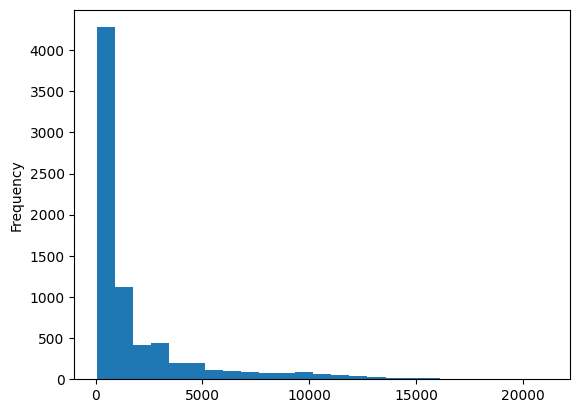

In [88]:

agosto_coordenadas.loc[  ((  agosto_coordenadas['duration(s)'] > 60   ) ) &
                        ((  agosto_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

##### Casos para corte dos passageiros validos

- Ha casos em que a duracao conexao de um passageiro eh superior a 47000 segundos (12h)
    - isso ocorre para passageiros que usam a linha diariamente
    - assim a dataInicio ocorre no fim de um dia e a dataFim no inicio de outro
- Com isso deve-se faze rum corte para retirar essas anomalia

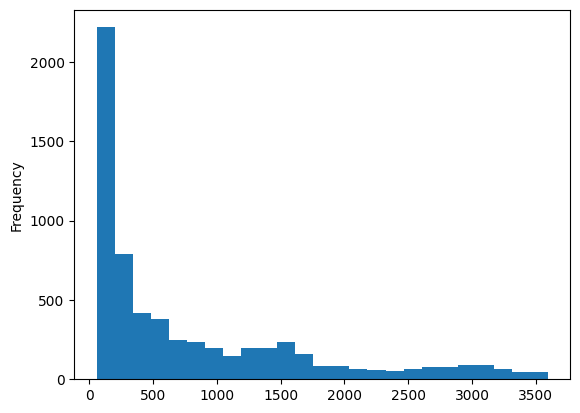

In [89]:
agosto_coordenadas.loc[  ((  agosto_coordenadas['duration(s)'] > 60   ) & (  agosto_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  agosto_coordenadas['distance(m)'] > 300   )  ), 'duration(s)'].plot(kind='hist', bins = 25);

#### Histograma Distance 
    - entre um minuto e uma hora de viagem
    - pelo menos 300m percorridos

##### Conclusao: Absoluta concentracao viagens de curta ducarao (ate 10 minutos)

    - 95% percentil de viagens é de 2km
    - Sao 230 viagens com mais de 2km, razoavel retirar sujeira

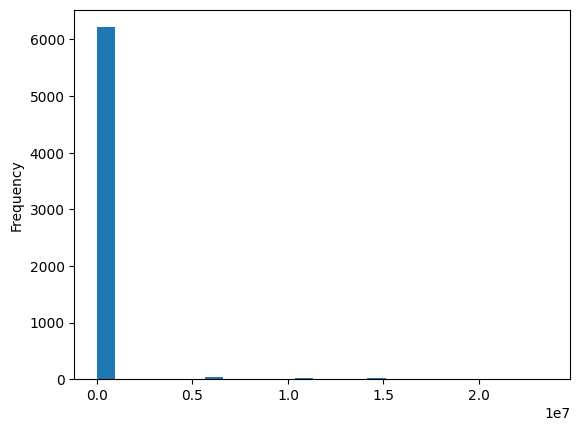

In [90]:

agosto_coordenadas.loc[  ((  agosto_coordenadas['duration(s)'] > 60   ) & (  agosto_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  agosto_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].plot(kind='hist', bins = 25);

In [91]:

agosto_coordenadas.loc[  ((  agosto_coordenadas['duration(s)'] > 60   ) & (  agosto_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  agosto_coordenadas['distance(m)'] > 300   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    6.305000e+03
mean     1.157935e+05
std      1.084762e+06
min      3.000423e+02
25%      4.430690e+02
50%      6.331133e+02
75%      1.004831e+03
80%      1.158835e+03
85%      1.365487e+03
90%      1.610112e+03
95%      2.060732e+03
max      2.360374e+07
Name: distance(m), dtype: float64

In [92]:

agosto_coordenadas.loc[  ((  agosto_coordenadas['duration(s)'] > 60   ) & (  agosto_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  agosto_coordenadas['distance(m)'] > 2000   )  ) ]

,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
42,2,25,Manha,2021-08-02 06:52:25,2021-08-02 13:02:59,7,2.419896e+03,1575.0,-22.829185,-47.065559,-22.818436,-47.063981
48,2,28,Tarde,2021-08-02 13:13:43,2021-08-02 18:47:18,11,2.799413e+03,2303.0,-22.828780,-47.065998,-22.821001,-47.066999
389,2,258,Manha,2021-08-02 07:03:28,2021-08-02 13:01:10,8,1.495674e+07,1981.0,-22.820949,-47.068032,-22.821332,-47.067798
433,2,284,Tarde,2021-08-02 13:03:20,2021-08-02 18:48:56,13,2.009911e+03,224.0,-22.816923,-47.063614,-22.815636,-47.063692
455,2,296,Manha,2021-08-02 07:06:32,2021-08-02 12:50:53,11,2.679961e+03,2130.0,-22.815524,-47.062611,-22.818087,-47.060537
...,...,...,...,...,...,...,...,...,...,...,...,...
168084,31,5111,Manha,2021-08-31 07:33:24,2021-08-31 12:09:22,5,8.642954e+06,850.0,-22.827286,-47.067423,22.827252,0.233333
168444,31,8108,Tarde,2021-08-31 14:43:53,2021-08-31 15:01:01,1,2.252024e+03,1028.0,-22.829584,-47.063187,-22.813778,-47.069640
168941,31,18133,Manha,2021-08-31 11:07:31,2021-08-31 11:18:56,1,2.017592e+03,685.0,-22.815663,-47.072624,-22.829264,-47.065433
168992,31,19454,Tarde,2021-08-31 14:29:51,2021-08-31 18:49:56,4,2.844082e+03,886.0,-22.816316,-47.072602,-22.815110,-47.066865


In [93]:

agosto_coordenadas.loc[  ((  agosto_coordenadas['duration(s)'] > 60   ) & (  agosto_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  agosto_coordenadas['distance(m)'] > 2000   )  ), 'distance(m)'].describe(percentiles=[ .25, .5, .75, .80, .85, .90, .95])
# sao 4030

count    3.460000e+02
mean     2.097369e+06
std      4.163494e+06
min      2.002944e+03
25%      2.218498e+03
50%      2.601222e+03
75%      2.294334e+06
80%      5.847058e+06
85%      6.085883e+06
90%      6.678508e+06
95%      1.132811e+07
max      2.360374e+07
Name: distance(m), dtype: float64

### Passageiros Validos

Foi adotado a duracao das viagens entre 60s e 1h

e com distancia percorrida entre 300m e 2,125km



In [94]:
validas_agosto = agosto_coordenadas.loc[  ((  agosto_coordenadas['duration(s)'] > 60   ) & (  agosto_coordenadas['duration(s)'] < 3600   ) ) &
                        ((  agosto_coordenadas['distance(m)'] > 300  ) & (  agosto_coordenadas['distance(m)'] < 2125   )  )].reset_index(drop=True).reset_index()
validas_agosto

,index,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
0,0,2,0,Manha,2021-08-02 06:50:32,2021-08-02 11:55:55,4,648.194837,1238.0,-22.827640,-47.061036,-22.826867,-47.061473
1,1,2,2,Manha,2021-08-02 06:50:34,2021-08-02 12:31:55,6,321.570532,1296.0,-22.827797,-47.060968,-22.828230,-47.060840
2,2,2,2,Tarde,2021-08-02 13:00:09,2021-08-02 17:21:27,6,688.998932,68.0,-22.827548,-47.061047,-22.828095,-47.060890
3,3,2,6,Tarde,2021-08-02 13:00:20,2021-08-02 17:21:29,8,327.120696,1413.0,-22.828331,-47.060797,-22.828301,-47.060828
4,4,2,8,Manha,2021-08-02 06:50:49,2021-08-02 12:57:30,8,534.419135,3023.0,-22.828972,-47.060551,-22.829673,-47.060916
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6010,6010,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6011,6011,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6012,6012,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6013,6013,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243


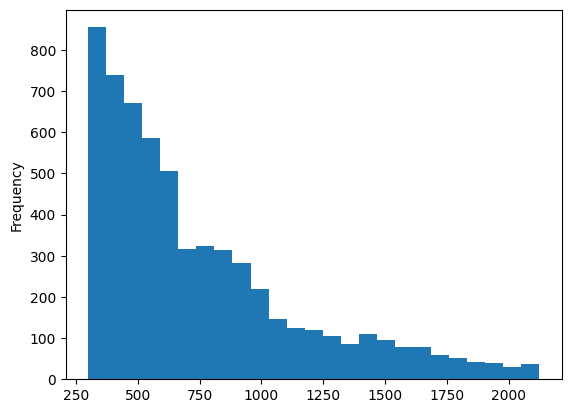

In [95]:
validas_agosto['distance(m)'].plot(kind='hist', bins = 25);

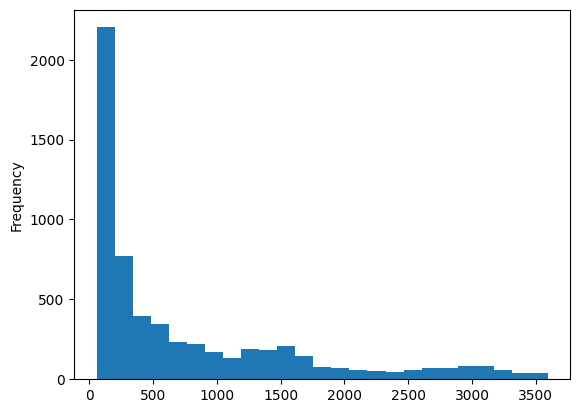

In [96]:
validas_agosto['duration(s)'].plot(kind='hist', bins = 25);

In [97]:
# validas_agosto.to_excel('viagens_validas_agosto.xlsx', engine = 'openpyxl')

In [98]:
validas_agosto.loc[((validas_agosto['dataFim'] - validas_agosto['dataInicio']).dt.total_seconds()  < validas_agosto['duration(s)'])]

,index,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF
145,145,2,1149,Manha,2021-08-02 08:27:36,2021-08-02 08:40:26,2,1170.274701,771.0,-22.822157,-47.069482,-22.818068,-47.061158
169,169,2,1715,Manha,2021-08-02 09:10:51,2021-08-02 09:37:24,2,658.963495,1597.0,-22.814045,-47.071320,-22.813882,-47.071179
170,170,2,1765,Manha,2021-08-02 09:14:27,2021-08-02 09:19:51,2,912.831115,350.0,-22.820343,-47.068292,-22.818135,-47.062800
177,177,2,2183,Manha,2021-08-02 11:02:02,2021-08-02 11:17:52,2,1969.311808,952.0,-22.816097,-47.072504,-22.829244,-47.065443
182,182,2,2250,Manha,2021-08-02 11:11:53,2021-08-02 11:17:47,2,1967.593988,363.0,-22.829600,-47.061537,-22.818682,-47.072291
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,6008,31,93049,Tarde,2021-08-31 15:31:56,2021-08-31 15:33:16,2,1651.905190,160.0,-22.826262,-47.067667,-22.831246,-47.063677
6009,6009,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6010,6010,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974
6011,6011,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974


In [99]:
validas_agosto.device_id.value_counts()

253      41
275      41
889      40
292      38
8070     37
         ..
37304     1
34922     1
33937     1
2876      1
93183     1
Name: device_id, Length: 2252, dtype: int64

## validas_agosto

In [100]:
validas_agosto.groupby(pd.Grouper(key='dataInicio', freq='1h')).agg(   {
                                                                          'sequence':'count'
}    )#.plot(kind='bar');

,sequence
dataInicio,
2021-08-02 06:00:00,24
2021-08-02 07:00:00,49
2021-08-02 08:00:00,20
2021-08-02 09:00:00,9
2021-08-02 10:00:00,0
...,...
2021-08-31 15:00:00,9
2021-08-31 16:00:00,4
2021-08-31 17:00:00,4


## Continuacao

- com os pontos de chegada e saida das viagens validas 
- agrupar os pontos por intervalo de tempo (aqui vai ficar a parametrizacao)
- dai para cara intervalo horario vamos ter uma tabela esparsa de origem destino

    - Serao 2 picos, manha e tarde
    - por dia sao 2 matrizes origem/destino
    - sao, em media, 20 dias por mes
    - potencialmente 60 matrizes
    